In [1]:
%matplotlib inline
#inline magic command to make sure all pictures are in line with each cell

#Installing libraries
print("INSTALLING LIBRARIES....")
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import matplotlib.patches as patches
import random
print("LIBRARIES INSTALLED!")

INSTALLING LIBRARIES....


2023-02-21 21:02:30.994439: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


LIBRARIES INSTALLED!


In [2]:
#Importing preprocess library defined by Author: Ishaipiriyan Karunakularatnam
import preprocess_dataset as pre

INSTALLING LIBRARIES....
LIBRARIES INSTALLED!


# Pre-Processing the dataset

In [3]:
MAX_LABELS = pre.getMaxLabels()
IMG_SIZE = pre.getImgSize()

In [4]:
src_path = "./cord-v2/data/"
tImages, tLabels = pre.getTrainDataset(src_path)

In [5]:
print("Pre-processing the datasets...")

train_images, (train_bboxes, train_conf_scores) = pre.pre_process_images(tImages), pre.pre_process_labels(tLabels, dense=True)

print("Training Data: Processed")

Pre-processing the datasets...
Training Data: Processed


In [6]:
train_images.shape

(800, 512, 512, 3)

# Model

In [7]:
#CORE CONSTANTS
IMG_INDEX = 1 #Min is 0, Max is 799
BATCH = 16
EPOCHS = 50
L_RATE = 0.001

In [8]:
training_dataset = tf.data.Dataset.from_tensor_slices((train_images,(train_conf_scores, train_bboxes)))
training_dataset = training_dataset.shuffle(buffer_size=len(train_images))
training_dataset = training_dataset.batch(BATCH)
training_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

2023-02-21 21:04:09.305465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 22), dtype=tf.int64, name=None), TensorSpec(shape=(None, 22, 4), dtype=tf.float64, name=None)))>

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras import backend
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError

In [151]:
def combined_loss(y_true, y_pred):
    #Splitting the true and prediction into confidence scores and bounding boxes
    true_conf  = y_true[0]
    true_box  = y_true[1]
    pred_conf = y_pred[0]
    pred_box = y_pred[1]
   
    
    #Defining the mask for confidence scores equaling 1
    mask = backend.cast(backend.equal(true_conf, 1), backend.floatx())
    #Calculating the confidence loss for all confidences and then applying mask
    #By applying mask, only calculating loss for 1 confidence data
    bce = BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    conf_loss = bce(true_conf, pred_conf * mask)
    conf_loss = backend.mean(conf_loss)
    
    #Calculating the bounding box loss for all bounding boxes and then applying mask
    #Same reason as above but for bounding boxes
    #Manually defining mean squared error as to apply the mask
    true_box = backend.cast(true_box, 'float32')
    bbox_loss = backend.square(true_box - pred_box)
    bbox_loss = backend.sum(bbox_loss, axis=-1)
    bbox_loss = backend.mean(bbox_loss * mask)
    
    return conf_loss, bbox_loss


In [152]:
def averageGradients(conf_gradients, bbox_gradients):
    gradients = []
    for index, conf_grad in enumerate(conf_gradients[:28]):
        bbox_grad = bbox_gradients[index]
        
        if (conf_grad != None) and (bbox_grad != None):
            avg_grad = conf_grad + bbox_grad
            avg_grad /= 2

            gradients.append(avg_grad)
        elif (conf_grad == None):
            gradients.append(bbox_grad)
        else:
            gradients.append(conf_grad)
    
    
    return gradients

In [153]:
class TextDetectorModel(keras.Model):
    def __init__(self, *args, **kargs):
        super().__init__(*args, **kargs)
        self.comb_loss_tracker = keras.metrics.Mean(name="comb_loss")
        self.conf_loss_tracker = keras.metrics.Mean(name="conf_loss")
        self.bbox_loss_tracker = keras.metrics.Mean(name="bbox_loss")
        self.conf_acc_tracker = keras.metrics.Accuracy(name="conf_accuracy")
        self.bbox_acc_tracker = keras.metrics.Accuracy(name="bbox_accuracy")
    
    def train_step(self, data):
        x, y = data
        
        conf_true, bbox_true = y[0], y[1]
        with tf.GradientTape(persistent=True) as tape:
            y_pred = self(x, training=True) #Forward pass
            
            conf_pred, bbox_pred = y_pred[0], y_pred[1]
            
            conf_loss, bbox_loss = combined_loss(y, y_pred)
            
            #print("conf_true shape:", conf_true.shape)
            #print("conf_pred shape:", conf_pred.shape)
            #print("bbox_true shape:", bbox_true.shape)
            #print("bbox_pred shape:", bbox_pred.shape)
            
            #print("conf_loss:", conf_loss)
            #print("bbox_loss:", bbox_loss)
        
        #Compute the gradients
        trainable_vars = self.trainable_variables
        #print(len(trainable_vars))
        gradients_conf_loss = tape.gradient(conf_loss, trainable_vars)
        gradients_bbox_loss = tape.gradient(bbox_loss, trainable_vars)
        
        """
        print("-------- CONFIDENCE LOSS --------")
        print("="*80)
        for i in gradients_conf_loss:
            print(i)
            print("="*80)
        
        print("-------- BOUNDING BOX LOSS --------")
        print("="*80)
        for i in gradients_bbox_loss:
            print(i)
            print("="*80)
        """
        gradients = averageGradients(gradients_conf_loss, gradients_bbox_loss)
        #print("-------- Gradients --------")
        #print("="*80)
        #for i in gradients:
        #    print(i)
        #    print("="*80)

        #Update the weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        #Compute the loss metrics
        self.conf_loss_tracker.update_state(conf_loss)
        self.bbox_loss_tracker.update_state(bbox_loss)
        self.comb_loss_tracker.update_state(conf_loss + bbox_loss)
        
        #Compute the accuracy metrics
        self.conf_acc_tracker.update_state(conf_true, conf_pred)
        self.bbox_acc_tracker.update_state(bbox_true, bbox_pred)
        return {"Combined Loss": self.comb_loss_tracker.result(), "Confidence Score Loss": self.conf_loss_tracker.result(),
               "Bounding Box Loss": self.bbox_loss_tracker.result(), "Confidence Score Accuracy": self.conf_acc_tracker.result(),
               "Bounding Box Accuracy": self.bbox_acc_tracker.result()}
    
    @property
    def metrics(self):
        return [self.comb_loss_tracker, self.conf_loss_tracker, self.bbox_loss_tracker, self.conf_acc_tracker, self.bbox_acc_tracker]

In [154]:
def getFeatureExtracter():
    # Defining the input layer
    input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Using vgg16 as the feature extractor
    featureExtractor = VGG16(weights="imagenet", include_top=False, input_tensor=input_layer)
    
    return input_layer, featureExtractor

In [155]:
def getModel():
    num_labels = MAX_LABELS
    
    input_layer, fe_layer = getFeatureExtracter()
    
    x = fe_layer.output
    x = Flatten()(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    
    confScores = Dense(1 * num_labels, activation="sigmoid", name="Confidence_Scores")(x)
    Bbox_coords = Dense(4 * num_labels, activation="sigmoid", name="BBox_regression")(x)
    Bbox_coords_RS = Reshape((num_labels, 4), name="Bbox")(Bbox_coords)
    
    model = TextDetectorModel(inputs=input_layer, outputs=[confScores, Bbox_coords_RS])
    
    model.compile(optimizer="adam")
    return model
    
    

In [156]:
def train(save_path, dataset, epoch_range):
    model = getModel()
    
    callback_cp = tf.keras.callbacks.ModelCheckpoint(
        filepath=save_path, verbose=1, save_weights_only=True,
        save_freq= "epoch")
    
    train_history = model.fit(dataset, batch_size=BATCH, callbacks = [callback_cp], epochs=epoch_range)
    
    return model, train_history

In [157]:
sample_model = getModel()

In [158]:
save_path = "./Saved Model/DO_Detection_VGG16_Custom_Model_Training/"

In [159]:
model, history = train(save_path, training_dataset, epoch_range=5)

Epoch 1/5
 1/50 [..............................] - ETA: 43:34 - Combined Loss: 0.1798 - Confidence Score Loss: 0.1052 - Bounding Box Loss: 0.0746 - Confidence Score Accuracy: 0.0000e+00 - Bounding Box Accuracy: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
test_images, test_labels = pre.getTestDataset(src_path)

In [ ]:
all_layers = model.layers

In [ ]:
for layer in all_layers:
    print(layer.name)

In [ ]:
layer_1_model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [96]:
test_data = test_images[3]
test_data = img_to_array(test_data.resize((IMG_SIZE,IMG_SIZE)))
test_data = np.expand_dims(test_data, axis=0)
    
preds = layer_1_model.predict(test_data)

1/1 [==============================] - 0s 53ms/step


In [97]:
preds.shape

(1, 512, 512, 64)

In [105]:
final = model.predict(test_data)

1/1 [==============================] - 1s 973ms/step


In [112]:
final

[array([[1.00000000e+00, 2.22323749e-07, 1.38660725e-02, 1.63698749e-10,
         9.99997377e-01, 5.27649361e-04, 8.40556531e-05, 4.17229305e-17,
         5.48610956e-18, 2.66029702e-18, 1.66185900e-18, 2.88162739e-19,
         3.91797706e-27, 3.74523619e-29, 3.68241684e-31, 4.22790633e-24,
         1.17879537e-31, 3.36830780e-27, 6.64369237e-25, 2.09283792e-31,
         5.32902709e-29, 1.73413877e-29]], dtype=float32),
 array([[[1.00000000e+00, 9.91212845e-01, 1.00000000e+00, 1.07008204e-01],
         [4.08586375e-02, 1.28119404e-09, 1.00000000e+00, 1.00000000e+00],
         [2.87622470e-07, 2.70890776e-08, 1.00000000e+00, 9.99998868e-01],
         [4.77321725e-03, 1.87570439e-08, 1.00000000e+00, 1.00000000e+00],
         [7.52316829e-13, 1.34852863e-13, 1.00000000e+00, 1.00000000e+00],
         [7.46281455e-13, 3.92109779e-14, 1.00000000e+00, 1.00000000e+00],
         [2.06516384e-20, 1.99368330e-14, 1.00000000e+00, 1.00000000e+00],
         [6.27722684e-17, 1.29993011e-14, 1.0000000

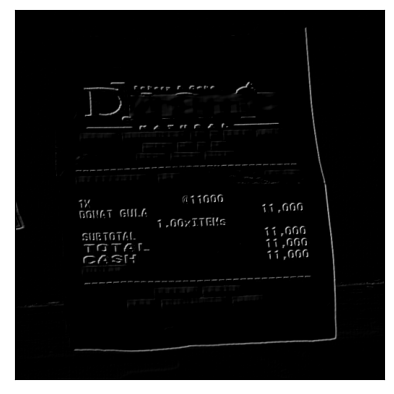

In [101]:
# plot all 64 maps in an 8x8 squares
square = 1
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(preds[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
plt.show()

In [ ]:
epochs_range = range(10)

plt.plot(epochs_range, history.history["loss"], label='Training Loss')
plt.plot(epochs_range, history.history["Confidence_Scores_loss"], label='Confidence_Scores Loss')
plt.plot(epochs_range, history.history["Bbox_loss"], label='BBox Coordinates Loss')
plt.legend(loc='upper right')
plt.show()

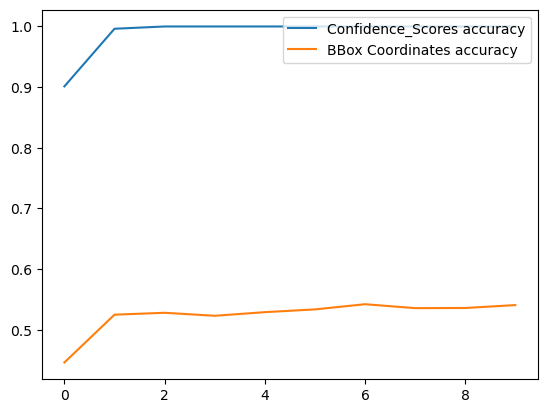

In [26]:
plt.plot(epochs_range, history.history["Confidence_Scores_accuracy"], label='Confidence_Scores accuracy')
plt.plot(epochs_range, history.history["Bbox_accuracy"], label='BBox Coordinates accuracy')
plt.legend(loc='upper right')
plt.show()

In [27]:
history.history.keys()

dict_keys(['loss', 'Confidence_Scores_loss', 'Bbox_loss', 'Confidence_Scores_accuracy', 'Bbox_accuracy'])

In [16]:
model = keras.models.load_model(save_path + "Model/")

In [18]:
test_images, test_labels = pre.getTestDataset(src_path)

checkpoint = ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=True,
    monitor="val_loss",
    mode="min",
    save_best_only=True
) 

In [43]:
def unnormalize(box, width, height):
    return [
        box[0] * width,
        box[1] * height,
        box[2] * width,
        box[3] * height
    ]

def test_image(idx):
    test_data = test_images[idx]
    tl = eval(test_labels[idx])
    w,h = tl['meta']['image_size']['width'], tl['meta']['image_size']['height']

    test_data = img_to_array(test_data.resize((IMG_SIZE,IMG_SIZE)))
    test_data = np.expand_dims(test_data, axis=0)
    
    preds = model.predict(test_data)
    
    isPos, dBox = preds
    
    print("Confidence Scores:")
    print(isPos)
    print("="*30)
    print("Boxes")
    print([unnormalize(box, w,h) for box in dBox])
    
    boxes = []
    poses = []
    for index, i in enumerate(isPos[0]):
        if i >= 0.5:
            boxes.append(dBox[0][index])
            poses.append(i)
    
    norm_boxes = [unnormalize(box, w, h) for box in boxes]
    
    fig, ax = plt.subplots()

    ax.imshow(test_images[idx])
    for i in norm_boxes:
        x1,y1,x3,y3 = i
        bbox = patches.Rectangle((x1, y1), (x3-x1), (y3-y1), linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(bbox)
    
    gt_bbox = pre.retreiveCoordinates(tl)
    #iou = inter_over_union(gt_bbox, box)
    
    for i in gt_bbox:
        x1,y1,x3,y3 = i
        bbox_gt = patches.Rectangle((x1, y1), (x3-x1), (y3-y1), linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(bbox_gt)
        
    plt.title("WxH: ({0},{1})".format(w, h))
    plt.axis('off')
    plt.show()

1/1 [==============================] - 1s 587ms/step
Confidence Scores:
[[1.0000000e+00 8.3330756e-01 2.4182704e-08 3.2073759e-26 8.8055323e-31
  6.3952123e-36 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]
Boxes
[[array([9.6000000e+02, 3.0193818e-01, 9.6000000e+02, 5.6069922e+02],
      dtype=float32), array([2.1931878e-03, 2.6497120e-15, 1.2800000e+03, 1.2800000e+03],
      dtype=float32), array([1.1963583e-12, 6.1857322e-20, 9.6000000e+02, 9.6000000e+02],
      dtype=float32), array([2.8890718e-20, 6.6528420e-23, 1.2800000e+03, 1.2800000e+03],
      dtype=float32)]]


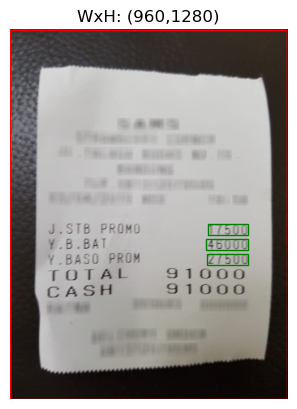

In [44]:
test_image(1)

1/1 [==============================] - 0s 167ms/step


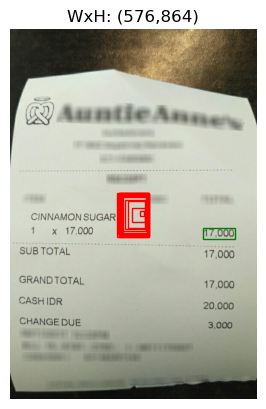

In [40]:
test_image(10)

1/1 [==============================] - 0s 165ms/step


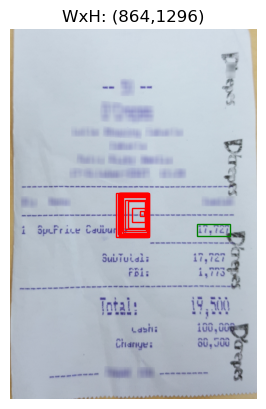

In [41]:
test_image(50)

1/1 [==============================] - 0s 168ms/step


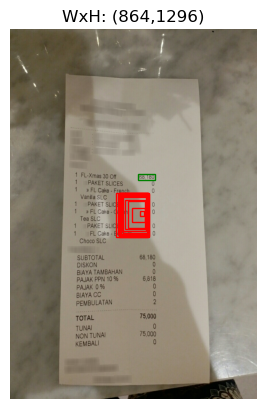

In [42]:
test_image(99)

In [43]:
#model.save("./Save-Models/Initial-Base-Model/")

In [44]:
# Need to define custom loss function to penalize 1 conf data and not 0 conf data